In [1]:
from tqdm import tqdm
import torch
import random
import numpy as np
import pandas as pd
import anndata
from anndata import read_h5ad
import torch.utils.data as data
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.nn as nn
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
architectures = {'m256': ([256,128,64,32],[0,0,0,0]),
                 'm512': ([512,256,128,64],[0, 0.3, 0.2, 0.1]),
                 'm1024': ([1024, 512, 256, 128],[0, 0.6, 0.3, 0.1])}
class simdatset(data.Dataset):
    def __init__(self,X,Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        x = torch.from_numpy(self.X[index]).float().to(device)
        y = torch.from_numpy(self.Y[index]).float().to(device)
        return x, y

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_units, dropout_rates):
        super().__init__()
        self.hidden_units = hidden_units
        self.dropout_rates = dropout_rates
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.model = self._mlp()

    def forward(self,x):
        # x: (n sample, m gene)
        # output: (n sample, k cell proportions)
        return self.model(x)

    def _mlp(self):
        mlp = nn.Sequential(nn.Linear(self.input_dim,self.hidden_units[0]),
                            nn.Dropout(self.dropout_rates[0]),
                            nn.ReLU(),
                            nn.Linear(self.hidden_units[0], self.hidden_units[1]),
                            nn.Dropout(self.dropout_rates[1]),
                            nn.ReLU(),
                            nn.Linear(self.hidden_units[1], self.hidden_units[2]),
                            nn.Dropout(self.dropout_rates[2]),
                            nn.ReLU(),
                            nn.Linear(self.hidden_units[2], self.hidden_units[3]),
                            nn.Dropout(self.dropout_rates[3]),
                            nn.ReLU(),
                            nn.Linear(self.hidden_units[3], self.output_dim),
                            nn.Softmax(dim=1))
        return mlp


def initialize_weight(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data,0)
        
class scaden():
    def __init__(self, architectures, traindata, testdata=None, testlabel=None, test_ratio=0.5, lr=1e-4, batch_size=128,
                 epochs=20):
        self.architectures = architectures
        self.testratio = test_ratio
        self.model512 = None
        self.model256 = None
        self.model1024 = None
        self.testmodel = None
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.inputdim = None
        self.outputdim = None
        self.train_loader, self.val_loader, self.test_loader = self._load_data(traindata, testdata, testlabel)

    def _loss_func(self, pred, target):
        l1loss = nn.L1Loss()
        kldloss = nn.KLDivLoss()
        l2loss = nn.MSELoss()
        return l1loss(pred, target)  # +l2loss(pred,target)#+kldloss(pred,target)

    def _subtrain(self, model, optimizer):
        model.train()
        i = 0
        loss = []
        for i in tqdm(range(self.epochs)):
            for data, label in self.train_loader:
                optimizer.zero_grad()
                batch_loss = self._loss_func(model(data), label)
                batch_loss.backward()
                optimizer.step()
                loss.append(batch_loss.cpu().detach().numpy())
        return model, loss

    def score(self, model1, model2=None, model3=None, mode='val'):
        model1.eval()
        if model2 is not None and model3 is not None:
            model2.eval()
            model3.eval()
        CCC = 0
        RMSE = 0

        if mode == 'val':
            loader = self.val_loader
        elif mode == 'test':
            loader = self.test_loader

        for data, label in loader:
            if model2 is not None and model3 is not None:
                pred = (model1(data) + model2(data) + model3(data)) / 3
            else:
                pred = model1(data)
            new_pred = pred.reshape(pred.shape[0]*pred.shape[1],1)
            new_label = label.reshape(label.shape[0]*label.shape[1],1)
            RMSE += self.RMSE(new_pred.cpu().detach().numpy(), new_label.cpu().detach().numpy())
            CCC += self.CCCscore(new_pred.cpu().detach().numpy(), new_label.cpu().detach().numpy())
        return CCC / len(loader), RMSE / len(loader)
    
    def showloss(self, loss):
        plt.figure()
        plt.plot(loss)
        plt.xlabel('iteration')
        plt.ylabel('loss')
        #plt.title()
        #plt.savefig(str(z)+'_'+str(beta)+'_'+str(gamma)+'.png')
        plt.show()
        
    def train(self, mode='all'):
        if mode=='all':
            ##### train
            self.build_model()
            optimizer = torch.optim.Adam(self.model256.parameters(), lr=self.lr, eps=1e-07)
            print('train model256 now')
            self.model256, loss = self._subtrain(self.model256, optimizer)
            self.showloss(loss)
            print(self.score(self.model256, mode='test'))
            optimizer = torch.optim.Adam(self.model512.parameters(), lr=self.lr, eps=1e-07)
            print('train model512 now')
            self.model512, loss = self._subtrain(self.model512, optimizer)
            self.showloss(loss)
            print(self.score(self.model512, mode='test'))
            optimizer = torch.optim.Adam(self.model1024.parameters(), lr=self.lr, eps=1e-07)
            print('train model1024 now')
            self.model1024, loss = self._subtrain(self.model1024, optimizer)
            self.showloss(loss)
            print(self.score(self.model1024, mode='test'))
            ##### evalutaion on val_set
            print(self.score(self.model256, self.model512, self.model1024, mode='val'))
            ##### evaluation on test_set
            print(self.score(self.model256, self.model512, self.model1024, mode='test'))
        elif mode=='single':
            self.build_model(mode=mode)
            optimizer = torch.optim.Adam(self.testmodel.parameters(), lr=self.lr)
            print('train test model now')
            self.testmodel, loss = self._subtrain(self.testmodel,optimizer)
            self.showloss(loss)
            ##### evaluation on test_set
            print(self.score(self.testmodel, mode='test'))

    def preprocess(self, trainingdatapath, testx=None, testy=None, testlabel='seq'):
        if (testx is not None) and (testy is not None):
            pbmc = read_h5ad(trainingdatapath)
            donorA = pbmc[pbmc.obs['ds']=='donorA']
            donorC = pbmc[pbmc.obs['ds']=='donorC']
            data6k = pbmc[pbmc.obs['ds']=='data6k']
            data8k = pbmc[pbmc.obs['ds']=='data8k']
            train_data = anndata.concat([donorA,donorC,data6k,data8k])
            test_x = pd.read_csv(testx, sep='\t')
            test_y = pd.read_excel(testy)
            intersection_genes = list(test_x.index.intersection(train_data.var.index))
            test_x = test_x.loc[intersection_genes]
            simuvar = list(train_data.var.index)
            intersection_gene_position = []
            for gene in intersection_genes:
                intersection_gene_position.append(simuvar.index(gene))
            # intersection_gene_position = sorted(intersection_gene_position)
            selected = np.zeros((len(intersection_genes), len(train_data.X)))
            for i in range(selected.shape[0]):
                selected[i] = train_data.X.T[intersection_gene_position[i]]
            train_x = selected.T
            intersection_cell = list(test_y.columns.intersection(train_data.obs.columns))
            train_y = train_data.obs[intersection_cell].values
            ### re
            for i, values in enumerate(train_y):
                r_sum = np.sum(values)
                if r_sum == 0:
                    pass
                else:
                    train_y[i] = train_y[i] / r_sum
            ###
            test_y = test_y[intersection_cell]
            test_x = test_x.T
            test_x = test_x.values
            test_y = test_y.values
            ### re
            for i, values in enumerate(test_y):
                r_sum = np.sum(values)
                if r_sum == 0:
                    pass
                else:
                    test_y[i] = test_y[i] / r_sum
            ###
            assert test_x.shape[1] == train_x.shape[1]
            assert test_y.shape[1] == train_y.shape[1]
            return train_x, train_y, test_x, test_y
        else:
            pbmc = read_h5ad(trainingdatapath)
            
            pbmc1 = pbmc[pbmc.obs['ds']=='sdy67']
            microarray = pbmc[pbmc.obs['ds']=='GSE65133']
            
            donorA = pbmc[pbmc.obs['ds']=='donorA']
            donorC = pbmc[pbmc.obs['ds']=='donorC']
            data6k = pbmc[pbmc.obs['ds']=='data6k']
            data8k = pbmc[pbmc.obs['ds']=='data8k']
            
            if testlabel == 'seq':
                test = pbmc1
                train = anndata.concat([donorA,donorC,data6k,data8k])
            elif testlabel == 'microarray':
                test = microarray
                train = anndata.concat([donorA,donorC,data6k,data8k,pbmc1])
                
            train_y = train.obs.iloc[:,:-2].values
            test_y = test.obs.iloc[:,:-2].values
            #### variance cut off
            if testlabel == 'seq':
                label = test.X.var(axis=0) > 0.1
            elif testlabel == 'microarray':
                label = test.X.var(axis=0) > 0.01
            test_x_new = np.zeros((test.X.shape[0],np.sum(label)))
            train_x_new = np.zeros((train.X.shape[0],np.sum(label)))
            print(test_x_new.shape)
            k = 0
            for i in range(len(label)):
                if label[i] == True:
                    test_x_new[:,k] = test.X[:,i]
                    train_x_new[:,k] = train.X[:,i]
                    k += 1
            ####
            return train_x_new, train_y, test_x_new, test_y
    
    def _load_data(self, train_data, test_x=None, test_y=None):
        # process training data
        # test_x: n sample, m gene
        # test_y: n sample, k cell
        
        train_x, train_y, test_x, test_y = self.preprocess(train_data, test_x, test_y)
        train_x = np.log2(train_x + 1)
        test_x = np.log2(test_x + 1)
        self.inputdim = train_x.shape[1]
        self.outputdim = train_y.shape[1]
        train_x, val_x, train_y, val_y = \
            train_test_split(train_x, train_y, test_size=self.testratio)
        
        mms = MinMaxScaler()
        
        test_x = mms.fit_transform(test_x.T)
        test_x = test_x.T
        train_x = mms.fit_transform(train_x.T)
        train_x = train_x.T
        val_x = mms.fit_transform(val_x.T)
        val_x = val_x.T
        
        # use dataloader to load data
        train_loader = data.DataLoader(simdatset(train_x, train_y), batch_size=self.batch_size, shuffle=True)
        val_loader = data.DataLoader(simdatset(val_x, val_y), batch_size=self.batch_size, shuffle=True)
        test_loader = data.DataLoader(simdatset(test_x, test_y), batch_size=len(test_x), shuffle=False)
        return train_loader, val_loader, test_loader

    def build_model(self,mode='all'):
        if mode=='all':
            self.model256 = MLP(self.inputdim, self.outputdim, self.architectures['m256'][0], self.architectures['m256'][1])
            self.model512 = MLP(self.inputdim, self.outputdim, self.architectures['m512'][0], self.architectures['m512'][1])
            self.model1024 = MLP(self.inputdim, self.outputdim, self.architectures['m1024'][0],self.architectures['m1024'][1])
            self.model1024 = self.model1024.to(device)
            self.model512 = self.model512.to(device)
            self.model256 = self.model256.to(device)
            self.model256.apply(initialize_weight)
            self.model512.apply(initialize_weight)
            self.model1024.apply(initialize_weight)
        elif mode=='single':
            self.testmodel = MLP(self.inputdim, self.outputdim, self.architectures['m512'][0], self.architectures['m512'][1])
            self.testmodel = self.testmodel.to(device)
            
    def predict(self,mode='all'):
        if mode == 'all':
            self.model256.eval()
            self.model512.eval()
            self.model1024.eval()
        elif mode == 'single':
            self.testmodel.eval()
        for data, label in self.test_loader:
            if mode == 'all':
                pred = (self.model256(data) + self.model512(data) + self.model1024(data)) / 3
            elif mode == 'single':
                pred = self.testmodel(data)
        return pred.cpu().detach().numpy()

    def save(self):
        torch.save(self.model256.state_dict(), './model256.pth')
        torch.save(self.model512.state_dict(), './model512.pth')
        torch.save(self.model1024.state_dict(), './model1024.pth')

    def load(self, model256, model512, model1024):
        self.build_model()
        self.model256.load_state_dict(torch.load(model256))
        self.model512.load_state_dict(torch.load(model512))
        self.model1024.load_state_dict(torch.load(model1024))

    def RMSE(self, pred, true):
        return np.sqrt(np.mean(np.square(pred - true)))
    
    def CCC(self,pred,true):
        r = np.corrcoef(pred, true)[0, 1]
        mean_true = np.mean(true)
        mean_pred = np.mean(pred)
        # Variance
        var_true = np.var(true)
        var_pred = np.var(pred)
        # Standard deviation
        sd_true = np.std(true)
        sd_pred = np.std(pred)
        # Calculate CCC
        numerator = 2 * r * sd_true * sd_pred
        denominator = var_true + var_pred + (mean_true - mean_pred) ** 2
        ccc = numerator / denominator
        return ccc
    
    def CCCscore(self, y_pred, y_true):
        # pred: shape{n sample, m cell}
        ccc_value = 0
        for i in range(y_pred.shape[1]):
            r = np.corrcoef(y_pred[:, i], y_true[:, i])[0, 1]
            # print(r)
            # Mean
            mean_true = np.mean(y_true[:, i])
            mean_pred = np.mean(y_pred[:, i])
            # Variance
            var_true = np.var(y_true[:, i])
            var_pred = np.var(y_pred[:, i])
            # Standard deviation
            sd_true = np.std(y_true[:, i])
            sd_pred = np.std(y_pred[:, i])
            # Calculate CCC
            numerator = 2 * r * sd_true * sd_pred
            denominator = var_true + var_pred + (mean_true - mean_pred) ** 2
            ccc = numerator / denominator
            # print(ccc)
            ccc_value += ccc
        return ccc_value / y_pred.shape[1]
    
    def plot_scatter(self,mode='all'):
        ori = None
        pred = self.predict(mode)
        for data, label in self.test_loader:
            ori = label
            break
        ori = ori.cpu().detach().numpy()
        fig, ax = plt.subplots(pred.shape[1],sharex='col',sharey='row',figsize=(3,15),dpi=100)
        fig.suptitle('Results')
        cccValue = 0
        for i in range(pred.shape[1]):
            y = pred[:,i]
            x = ori[:,i]
            ax[i].scatter(x, y, s=10)
            z1 = np.polyfit(x, y, 1) # 用4次多项式拟合
            p1 = np.poly1d(z1)
            ccc = self.CCC(x,y)
            cccValue += ccc
            #print(p1) # 在屏幕上打印拟合多项式
            ax[i].text(0.1,0.8,str(ccc))
            yvals=p1(x) # 也可以使用yvals=np.polyval(z1,x)
            ax[i].set_xlim(0,1)
            ax[i].set_ylim(0,1)
            ax[i].plot(x, yvals, 'r',label='polyfit values')
        plt.show()

In [2]:
def reproducibility(seed=0):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

(12, 10134)


  0%|          | 0/10 [00:00<?, ?it/s]

train model256 now


100%|██████████| 10/10 [00:41<00:00,  4.11s/it]


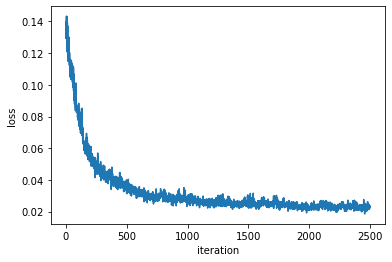

  0%|          | 0/10 [00:00<?, ?it/s]

(0.5201344504646849, 0.13022877275943756)
train model512 now


100%|██████████| 10/10 [01:08<00:00,  6.86s/it]


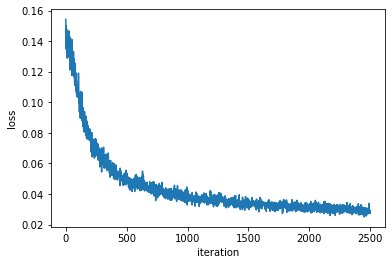

  0%|          | 0/10 [00:00<?, ?it/s]

(0.46267917754219684, 0.17994272708892822)
train model1024 now


100%|██████████| 10/10 [02:16<00:00, 13.62s/it]


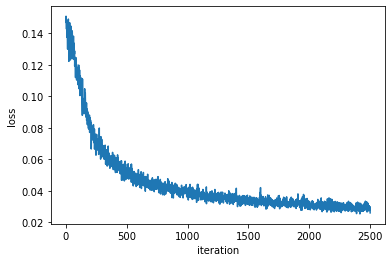

(0.480233977716905, 0.14393599331378937)
(0.9941741744402325, 0.0183873251080513)
(0.5287411515995435, 0.13939793407917023)


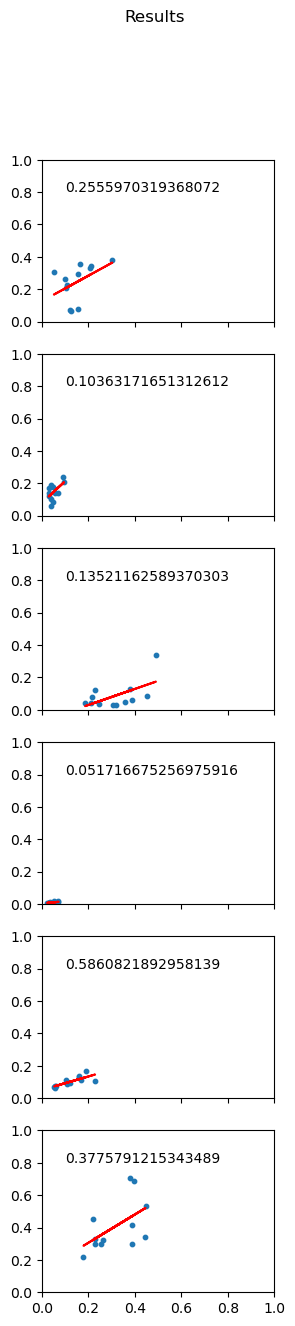

In [3]:
#PBMC1 CCC:0.5678356442979114, RMSE:0.12577371299266815
reproducibility(seed=2)
model = scaden(architectures,'pbmc_data.h5ad',test_ratio=0.001,batch_size=128,epochs=10)
model.train(mode='all')
#model.save()
model.plot_scatter('all')

In [4]:
# PBMC2 CCC:0.6906199985576614, RMSE:0.08162076771259308
# reproducibility(seed=1)
# model = scaden(architectures,'pbmc_data.h5ad','TPMPBMC.txt','PBMC2cellprop.xlsx',test_ratio=0.001,batch_size=128,epochs=10)
# model.train(mode='all')
# model.save()
# model.plot_scatter('all')